Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import scipy.io as sio
import xarray as xr
import matplotlib.dates as mdates
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

1.	Read the data and rearrange the longitudes so 180 is in the center of the grid.

In [2]:
filename_pattern  = '/home/voyager-sbarc/arc/sst/hadisst/HadISST_sst.nc'
ds = xr.open_dataset(filename_pattern)
ds

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and sup

In [3]:
ds_rolled = ds.roll(longitude=180, roll_coords=True)
ds_rolled

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 0.5 1.5 2.5 3.5 4.5 ... -3.5 -2.5 -1.5 -0.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 -1000.0 -1000.0 ... nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_info

2.	Crop the data to 30S-30N.

In [4]:
ds_subset = ds.sel(latitude=slice(30,-30))
ds_subset

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and supp

3.	Compute the annual cycle of SST fitting the first and second harmonics.

In [5]:
climatology = ds_subset.groupby('time.month').mean('time')
climatology

/home/nash/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (month, nv) float32 27027.584 27058.584 ... 27179.203 27210.203
    sst        (month, latitude, longitude) float32 19.316332 ... 21.992668

Create 1st two harmonics and add together

In [6]:
def fourier(ds,p):
    time = ds.month
    n = len(time) 
 
    ds,time = xr.broadcast(ds,time)

    f = 2.*np.pi*p/n
    ft = f*time

    sum_a = ds*np.cos(ft - 1.)
    sum_b = ds*np.sin(ft - 1.)
    coef_a = (2./n)*sum_a.sum('month',skipna=True)
    coef_b = (2./n)*sum_b.sum('month',skipna=True)

    return ft,coef_a, coef_b

def harmonic(ds):
    a0 = ds.mean('month',skipna=True)

    #-First Harmonic
    p     = 1
    ft,coef_a,coef_b = fourier(ds,p)
    harm1 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-Second Harmonic
    p     = 2
    ft,coef_a,coef_b = fourier(ds,p)
    harm2 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-First plus second
    combo = harm1 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    return combo

In [7]:
annual_cycle = harmonic(climatology)
annual_cycle

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (nv, latitude, longitude, month) float64 2.708e+04 ... 2.721e+04
    sst        (latitude, longitude, nv, month) float64 19.37 18.39 ... 21.99

4.	Remove the annual cycle from the monthly SST in each gridpoint

In [8]:
anomalies = ds_subset.groupby('time.month') - annual_cycle
anomalies.sst.shape

(1787, 60, 360, 2)

5.	Remove the long-term mean in each gridpoint - already done via harmonics

In [9]:
long_term_mean = anomalies.sst[:,:,:,0].mean('time', skipna=True)
print(long_term_mean.shape)

sst = anomalies.sst[:,:,:,0] - long_term_mean

/home/nash/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(60, 360)


6.	Weight the SST anomaly value in each gridpoint by the square of the cosine of the latitude

In [21]:
# Weight the data set according to weighting argument.
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)
wgts = xr.DataArray(wgts, coords=[sst.latitude], dims=['latitude'])
sst,weights = xr.broadcast(sst,wgts)
weighted_data = sst * weights
print(weighted_data.shape)
print(weights)

(1787, 60, 360)
<xarray.DataArray (time: 1787, latitude: 60, longitude: 360)>
array([[[0.932929, 0.932929, ..., 0.932929, 0.932929],
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        ...,
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        [0.932929, 0.932929, ..., 0.932929, 0.932929]],

       [[0.932929, 0.932929, ..., 0.932929, 0.932929],
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        ...,
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        [0.932929, 0.932929, ..., 0.932929, 0.932929]],

       ...,

       [[0.932929, 0.932929, ..., 0.932929, 0.932929],
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        ...,
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        [0.932929, 0.932929, ..., 0.932929, 0.932929]],

       [[0.932929, 0.932929, ..., 0.932929, 0.932929],
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        ...,
        [0.937452, 0.937452, ..., 0.937452, 0.937452],
        [0.932929, 0.93292

7.	Plot the standard deviation of the SST anomalies

In [11]:
std_dev = np.std(weighted_data, axis=0)
std_rolled = std_dev.roll(longitude=180, roll_coords=True)

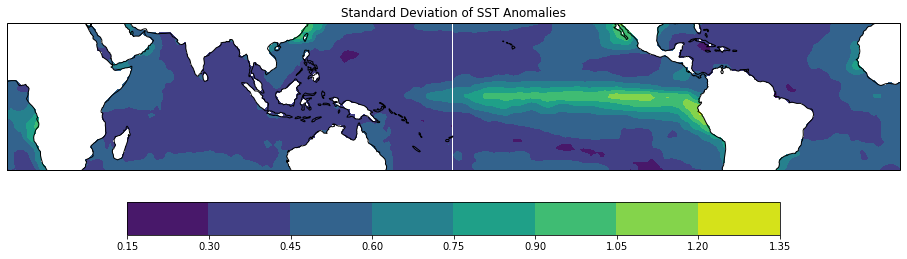

In [12]:
plt.figure(figsize=[16., 4.])
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-179.5))
ax.set_extent([sst.longitude.min(), sst.longitude.max(), sst.latitude.min(), sst.latitude.max()], crs=ccrs.PlateCarree(central_longitude=-179.5))
cf = plt.contourf(sst.longitude, sst.latitude, std_dev, transform=ccrs.PlateCarree())
plt.title('Standard Deviation of SST Anomalies')
plt.colorbar(cf, orientation='horizontal')
ax.coastlines()
plt.show()

8a.	The SST data consist of 1787 points in time by 21600 points in space.

In [13]:
[numtimes, numlats, numlons] = weighted_data.shape

## flatten lat and lon into 1 spatial location identifier
X = np.reshape(weighted_data.values, [numtimes, numlons*numlats])
X.shape

(1787, 21600)

In [14]:
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
nonMissingIndex = np.where(np.logical_not(np.isnan(X[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = X[:, nonMissingIndex]
print(dataNoMissing.shape)

(1787, 16378)


8b.	Compute the covariance matrix of SST anomalies using the time dimension

In [17]:
## Compute Covariance Matrix
numtimes, numnonMissing = dataNoMissing.shape
A = np.dot(dataNoMissing,np.transpose(dataNoMissing))/numnonMissing
A.shape

(1787, 1787)

Text(0.5, 1.0, 'Covariance Matrix')

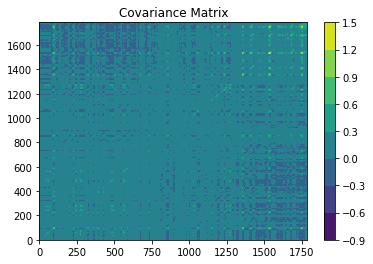

In [18]:
plt.contourf(A)
plt.colorbar()
plt.title('Covariance Matrix')

In [20]:
A, Lh, E = np.linalg.svd(A)
print(A.shape)
print(Lh.shape)
print(E.shape)

(1787, 1787)
(1787,)
(1787, 1787)
